# Importing Libraries required.

In [39]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import re
import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import cohen_kappa_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the data file as specified to read it endoded 'iso8859_2' 

In [0]:
df = pd.read_csv("/content/data.csv",encoding='iso8859_2')

We can see the data['text'] conatining all the messages which has latin text and also # hashtags. The total length is 3118.

In [3]:
df['text']

0       Barclays CEO stresses the importance of regula...
1       Barclays announces result of Rights Issue http...
2       Barclays publishes its prospectus for its ĺŁ5....
3       Barclays Group Finance Director Chris Lucas is...
4       Barclays announces that Irene McDermott Brown ...
                              ...                        
3113    Wishing you a happy and healthy Thanksgiving. ...
3114    WouldnĚ˘âÂă˘t it be great if your oven recog...
3115    Yesterday, these #HealthyKids lit up Broadway ...
3116    Yo-Jelly, Danone new brand in South Africa : t...
3117    Z Bhutta: Problems with food&amp;land systems ...
Name: text, Length: 3118, dtype: object

In [4]:
df.shape

(3118, 3)

The dataframe consists of 39 null values which are not usable and there are missing rows present in file. So, drop the rows.

In [5]:
df.isnull().sum()

category      39
screenname    39
text          39
dtype: int64

In [0]:
df = df.dropna()

In [7]:
df.isnull().sum()

category      0
screenname    0
text          0
dtype: int64

After dropping the rows we have 3079 data points or rows and 3 columns.

In [8]:
df.shape

(3079, 3)

In [9]:
df.head()

,category,screenname,text
0,Information,Barclays,Barclays CEO stresses the importance of regula...
1,Information,Barclays,Barclays announces result of Rights Issue http...
2,Information,Barclays,Barclays publishes its prospectus for its ĺŁ5....
3,Information,Barclays,Barclays Group Finance Director Chris Lucas is...
4,Information,Barclays,Barclays announces that Irene McDermott Brown ...


There are three categories in which the data has been classified in training data i.e.  Information, Dialouge, Action. We can see it is Imbalanced data set. To handle imbalance data set we can do undersmapling or oversmapling techniques such as Smote. But, for now we will try to run it as it is and try to find how our model works.

In [0]:
category_count = df['category'].value_counts()

In [11]:
category_count

Information    2129
Action          724
Dialogue        226
Name: category, dtype: int64

Text(0.5, 1.0, 'category visuals')

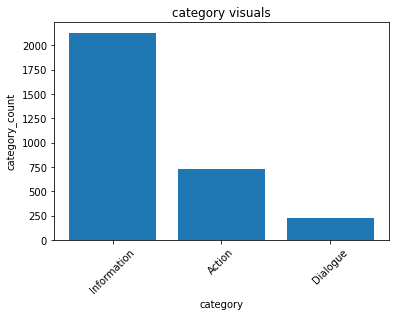

In [12]:
index = [1,2,3]
plt.bar (index, category_count)
plt.xticks(index, ['Information', 'Action', 'Dialogue'], rotation = 45)
plt.ylabel ('category_count')
plt.xlabel ('category')
plt.title ('category visuals')

In [0]:
df_new = df.copy()

In [0]:
df_new['category_id'] = pd.factorize(df.category)[0]

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3079 entries, 0 to 3117
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     3079 non-null   object
 1   screenname   3079 non-null   object
 2   text         3079 non-null   object
 3   category_id  3079 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 120.3+ KB


In [0]:
category_id_count = df_new['category_id'].value_counts()

In [17]:
category_id_count

0    2129
1     724
2     226
Name: category_id, dtype: int64

We have created the functions to clean the data and remove the stop words from the data given to find usefuk meaning of the data.

In [0]:
replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
# function to clean text data

def clean_reviews(reviews):
    reviews = [replace_1.sub("", line.lower()) for line in reviews]
    reviews = [replace_2.sub(" ", line) for line in reviews]
    return reviews

In [0]:
df_new['text'] = clean_reviews(df_new['text'])

In [0]:
df_new['text'] = clean_reviews(df_new['text'])

In [0]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]


In [0]:
for char in spec_chars:
    df_new['category'] = df_new['category'].str.replace(char, ' ')

In [0]:
def clean_words (raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))

In [0]:
df_new['clean_text'] = df_new['text'].apply(lambda x: clean_words(x))

In [25]:
df_new.isnull().sum()

category       0
screenname     0
text           0
category_id    0
clean_text     0
dtype: int64

After cleaning the data we split the test and train data to create a model check against the testing data and evalute the model built.  We have kept test data size 25% and 75% for training.

In [0]:
X = df_new['clean_text'] # Collection of documents
y = df_new['category'] # Target or the labels we want to predict 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [27]:
X_train.shape , y_train.shape

((2309,), (2309,))

After, train test split we should start design the classifier. Since, the inputs are texts we first need to convert them into numerical vectors to feed them into any machine learning algorithm. The vectorization of features are done using the following two methods.

We will be using bag of words method to create and build model. Firstly we use countvectorizer which assigns unique values to each words count the no of occorunces of the each rows consolidated. For 2309 train data we have 7729 vetors.

In [28]:

count_vect = CountVectorizer()
X_train_count_1 = count_vect.fit_transform(X_train)
X_train_count_1.shape

(2309, 7729)

TF-IDF: Its value represents the importance of a word to a document in a corpus. TF-IDF value is proportional to the frequency of a word in a document. It has same samples and features and there is no loss in data as seen above in countvector.

In [29]:


tfidf_transform = TfidfTransformer()
X_train_tfidf_1 = tfidf_transform.fit_transform(X_train_count_1)
X_train_tfidf_1.shape

(2309, 7729)

Now we will use different classifiers model to Build our model and will evalute our model on not only accuracy but precesion, recall and F1 socre. Because, we are dealing with imbalanced data set.

In [30]:

clf = MultinomialNB().fit(X_train_tfidf_1,y_train)
X_test_nb = count_vect.transform(X_test)
X_test_tfidf_clf = tfidf_transform.transform(X_test_nb)
predict_clf = clf.predict(X_test_tfidf_clf)
print("Accuracy:", metrics.accuracy_score(y_test,predict_clf))
print(metrics.classification_report(y_test,predict_clf,target_names=df_new['category'].unique()))

Accuracy: 0.7805194805194805
              precision    recall  f1-score   support

 Information       0.78      0.40      0.53       171
      Action       1.00      0.08      0.16        59
    Dialogue       0.78      0.98      0.87       540

    accuracy                           0.78       770
   macro avg       0.85      0.49      0.52       770
weighted avg       0.80      0.78      0.74       770



In [0]:
from sklearn.metrics import make_scorer, accuracy_score
def kappa(y, y_pred, **kargs):
    return cohen_kappa_score(y,y_pred)

kappa = make_scorer(kappa)

In [0]:
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
bagg = BaggingClassifier(base_estimator=tree)
boost = AdaBoostClassifier(base_estimator=tree)

In [0]:
param_grid_tree = {'criterion':['gini','entropy'], 'max_depth':[3,5,7,9]}
param_grid_rf = {'n_estimators':[100,200,500], 'max_depth':[3,5,7,9]}
param_grid_bagg = {'n_estimators':[100,200,500]}
param_grid_boost = {'n_estimators':[100,200,500], 'learning_rate':[0.0001,0.0003,0.0005]}

In [0]:
best_model_tree = GridSearchCV(estimator=tree,param_grid=param_grid_tree, scoring=kappa, cv=5)

best_model_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=kappa,  cv=5)

best_model_bagg = GridSearchCV(estimator=bagg,param_grid=param_grid_bagg, scoring=kappa,  cv=5)

best_model_boost = GridSearchCV(estimator=boost, param_grid=param_grid_boost, scoring=kappa,cv=5)

In [35]:
tree_1 =best_model_tree.fit(X_train_tfidf_1,y_train)
X_test_tree = count_vect.transform(X_test)
X_test_tfidf_tree = tfidf_transform.transform(X_test_tree)
predict_tree = tree_1.predict(X_test_tfidf_tree)

print("Accuracy:", metrics.accuracy_score(y_test,predict_tree))
print(metrics.classification_report(y_test,predict_tree,target_names=df_new['category'].unique()))

Accuracy: 0.8389610389610389
              precision    recall  f1-score   support

 Information       0.85      0.51      0.64       171
      Action       0.91      0.54      0.68        59
    Dialogue       0.83      0.97      0.90       540

    accuracy                           0.84       770
   macro avg       0.87      0.68      0.74       770
weighted avg       0.84      0.84      0.82       770



In [36]:
rf_1 =best_model_rf.fit(X_train_tfidf_1,y_train)
X_test_rf = count_vect.transform(X_test)
X_test_tfidf_rf = tfidf_transform.transform(X_test_rf)
predict_rf = rf_1.predict(X_test_tfidf_rf)

print("Accuracy:", metrics.accuracy_score(y_test,predict_rf))
print(metrics.classification_report(y_test,predict_rf,target_names=df_new['category'].unique()))

Accuracy: 0.7194805194805195
              precision    recall  f1-score   support

 Information       0.79      0.09      0.16       171
      Action       0.00      0.00      0.00        59
    Dialogue       0.72      1.00      0.84       540

    accuracy                           0.72       770
   macro avg       0.50      0.36      0.33       770
weighted avg       0.68      0.72      0.62       770



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
bagg_1 = best_model_bagg.fit(X_train_tfidf_1,y_train)
X_test_bagg = count_vect.transform(X_test)
X_test_tfidf_bagg = tfidf_transform.transform(X_test_bagg)
predict_bagg = bagg_1.predict(X_test_tfidf_bagg)

print("Accuracy:", metrics.accuracy_score(y_test,predict_bagg))
print(metrics.classification_report(y_test,predict_bagg,target_names=df_new['category'].unique()))

Accuracy: 0.8961038961038961
              precision    recall  f1-score   support

 Information       0.80      0.84      0.82       171
      Action       0.80      0.75      0.77        59
    Dialogue       0.94      0.93      0.93       540

    accuracy                           0.90       770
   macro avg       0.85      0.84      0.84       770
weighted avg       0.90      0.90      0.90       770



In [38]:
boost_1 = best_model_boost.fit(X_train_tfidf_1,y_train)
X_test_boost = count_vect.transform(X_test)
X_test_tfidf_boost = tfidf_transform.transform(X_test_boost)
predict_boost= boost_1.predict(X_test_tfidf_boost)

print("Accuracy:", metrics.accuracy_score(y_test,predict_boost))
print(metrics.classification_report(y_test,predict_boost,target_names=df_new['category'].unique()))

Accuracy: 0.8909090909090909
              precision    recall  f1-score   support

 Information       0.79      0.81      0.80       171
      Action       0.78      0.78      0.78        59
    Dialogue       0.93      0.93      0.93       540

    accuracy                           0.89       770
   macro avg       0.84      0.84      0.84       770
weighted avg       0.89      0.89      0.89       770



In [0]:
xg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0)
param_grid_xgb = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
xgb_search = GridSearchCV(estimator =xg, param_grid=param_grid_xgb, scoring=kappa,cv=5) 


In [50]:
xgb_1 = xgb_search.fit(X_train_tfidf_1,y_train)
X_test_xgb = count_vect.transform(X_test)
X_test_tfidf_xgb = tfidf_transform.transform(X_test_xgb)
predict_xgb = xgb_1.predict(X_test_tfidf_xgb)

print("Accuracy:", metrics.accuracy_score(y_test,predict_xgb))
print(metrics.classification_report(y_test,predict_xgb,target_names=df_new['category'].unique()))

Accuracy: 0.8805194805194805
              precision    recall  f1-score   support

 Information       0.83      0.75      0.79       171
      Action       0.85      0.66      0.74        59
    Dialogue       0.90      0.94      0.92       540

    accuracy                           0.88       770
   macro avg       0.86      0.79      0.82       770
weighted avg       0.88      0.88      0.88       770



From all above models we see that, Boosted trees and Bagging have given good results. Also Decesion tree has really given good results comparatively. As, it did not took much time to run unlike Ensemble models.

Going forward we can also try to use some Deep neural network models and try to get better model. Also, to get better model we need more data to train model. The data was small hence learning process could be affected. 

On other hand, There has been BERT model works on LSTM model which was develoed by Google AI can also explored.